# Automotive industry sites

In [1]:
# Subscribe to api.insee.fr and get your credentials!
# Save your credentials with init_conn function :
# from pynsee.utils.init_conn import init_conn
# init_conn(insee_key="my_insee_key", insee_secret="my_insee_secret")

# Beware : any change to the keys should be tested after having cleared the cache
# Please do : from pynsee.utils import clear_all_cache; clear_all_cache()"

In [8]:
import geopandas
import pandas as pd
import numpy as np
import pyproj
from shapely.ops import transform

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib, descartes
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from pynsee import *

In [2]:
import geopandas
import pandas as pd
import numpy as np
import pyproj
from shapely.ops import transform

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib, descartes
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from pynsee import *

In [3]:
# get activity list
naf5 = get_activity_list('NAF5')

# search data in SIRENE database
data = search_sirene(variable = "activitePrincipaleEtablissement",
                   pattern = '29.10Z', kind = 'siret') 

Getting legal entities: 100%|██████████| 12/12 [00:01<00:00,  7.28it/s]



!!! This function may return personal data, please check and
 comply with the legal framework relating to personal data protection !!!


In [3]:
# keep only businesses with more then 100 employees
df = data.loc[data['effectifsMinEtablissement'] > 100]
df = df.reset_index(drop=True)

# find latitude and longitude of all businesses
df = df.get_location()

Getting location: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [6]:
# make geodataframe
gdf = geopandas.GeoDataFrame(df)
gdf = gdf.reset_index(drop=True)
gdf = gdf.sort_values(by=['effectifsMinEtablissement'], ascending=False)

In [4]:
# get map - departement limits
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
mapdep = mapdep.translate()

# conversion to geopandas df
mapdepgeo = geopandas.GeoDataFrame(mapdep)
mapdepgeo.head()

Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data
Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/399f6d97ce4631c4e02c487406744440
Set update=True to get the most up-to-date data


,id,nom_m,nom,insee_dep,insee_reg,geometry,bbox,crs
0,DEPARTEM_GLP_00000000001,GUADELOUPE,Guadeloupe,971,01,"MULTIPOLYGON (((-739144.768 6296095.811, -7391...","[-6880639.76094451, 1785277.73400778, -6790707...",EPSG:3857
1,DEPARTEM_MTQ_00000000001,MARTINIQUE,Martinique,972,02,"MULTIPOLYGON (((-756752.387 6056818.795, -7567...","[-6815985.71107846, 1618842.96967012, -6769303...",EPSG:3857
2,DEPARTEM_REU_00000000001,LA REUNION,La Réunion,974,04,"MULTIPOLYGON (((-807378.564 5867965.281, -8072...","[6146675.55743685, -2438398.99690376, 6215705....",EPSG:3857
3,DEPARTEM_GUF_00000000001,GUYANE,Guyane,973,03,"MULTIPOLYGON (((-726100.917 5717722.930, -7260...","[-6078310.30343627, 235055.06017674, -5746205....",EPSG:3857
4,DEPARTEM_MYT_00000000001,MAYOTTE,Mayotte,976,06,"MULTIPOLYGON (((-553726.624 5453062.725, -5537...","[5011418.77897208, -1460351.156634, 5042772.00...",EPSG:3857


In [5]:
# make cleaned labels
conditions = [gdf['denominationUniteLegale'].str.contains('RENAULT SAS'),
              gdf['denominationUniteLegale'].str.contains('PSA AUTOMOBILES'), 
              gdf['denominationUniteLegale'].str.contains('[^RENAULT SAS]|[^PSA AUTOMOBILES]')]

values = ['RENAULT SAS','PSA AUTOMOBILES', 'OTHER']

gdf['label'] = np.select(conditions, values)

In [9]:
def _convert_polygon(geo, crs_in='EPSG:4326', crs_out='EPSG:3857'):
    
    if geo is not None:
        crsIn = pyproj.CRS(crs_in)
        crsOut = pyproj.CRS(crs_out)

        project = pyproj.Transformer.from_crs(crsIn, crsOut, always_xy=True).transform
        geo_converted = transform(project, geo)

        return geo_converted

# convert openstreetmap data from crs 4326 to crs 3857
gdf['geometry'] = gdf['geometry'].apply(lambda x: _convert_polygon(x))

gdf["crs"] = 'EPSG:3857'

In [10]:
def _convert_polygon(geo, crs_in='EPSG:4326', crs_out='EPSG:3857'):
    
    if geo is not None:
        crsIn = pyproj.CRS(crs_in)
        crsOut = pyproj.CRS(crs_out)

        project = pyproj.Transformer.from_crs(crsIn, crsOut, always_xy=True).transform
        geo_converted = transform(project, geo)

        return geo_converted

# convert openstreetmap data from crs 4326 to crs 3857
gdf['geometry'] = gdf['geometry'].apply(lambda x: _convert_polygon(x))

gdf["crs"] = 'EPSG:3857'

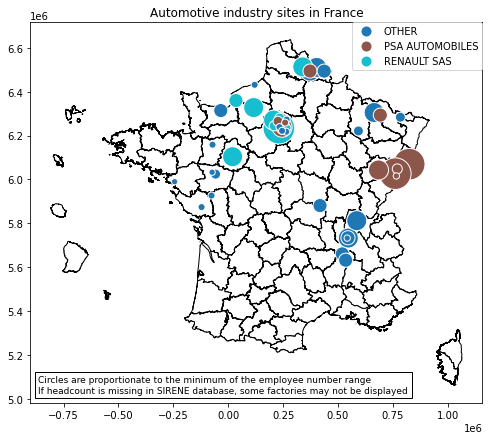

In [13]:
# annotation
txt = 'Circles are proportionate to the minimum of the employee number range'
txt += '\nIf headcount is missing in SIRENE database, some factories may not be displayed'

#plot
ax = mapdepgeo.plot(color='white', edgecolor='black', figsize = (15,7))
plt.title('Automotive industry sites in France')
gdf.plot(ax=ax, 
         column = 'label',
         edgecolor='white',
         markersize=gdf.effectifsMinEtablissement/5,
         legend=True,
         legend_kwds={'bbox_to_anchor': (1,1),
                       'loc':1, 'borderaxespad': 0})

at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc='lower left')
ax.add_artist(at)

plt.show()